In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score,precision_recall_curve, auc, roc_curve
from tqdm.notebook import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/modelowanie/projekt/combined_data.csv'
df = pd.read_csv(path)

#HER2-neg
df = df[df['characteristics_ch1_4'].astype(str).str.strip().str.endswith("N")].copy()

#data preprocessing
df.drop(columns=['title'], inplace=True)
geo_col = ['geo_accession']
characteristics_cols = [col for col in df.columns if 'characteristics' in col.lower()]
other_cols = [col for col in df.columns if 'characteristics' not in col.lower() and col != 'geo_accession']


#clinical
df_meta = df[geo_col + characteristics_cols]
df_meta.set_index("geo_accession", inplace=True)
df_meta = df_meta.copy()
new_column_names = [str(el).split(':')[0].strip() for el in df_meta.iloc[0, :]]
df_meta.columns = new_column_names

for col in df_meta.columns:
    df_meta[col] = df_meta[col].astype(str).str.split(':').str[-1].str.strip()

#expresion
df_gene_expression = df[geo_col + other_cols]
df_gene_expression.set_index("geo_accession", inplace=True)
df_gene_expression_clean = df_gene_expression.loc[:, ~df_gene_expression.columns.str.startswith("AFFX-")]

df_expr_final = df_gene_expression_clean.T

#final check
common_samples = df_expr_final.columns.intersection(df_meta.index)
df_expr_final = df_expr_final[common_samples]
df_meta_final = df_meta.loc[common_samples]
df_expr_final.index.name = 'gene'

print(f"Expresion matrix: {df_expr_final.shape} (genes × probes)")
print(f"Clinical data: {df_meta.shape} (probes × characteristics)")


/tmp/ipython-input-3-2644258436.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Expresion matrix: (22215, 485) (genes × probes)
Clinical data: (485, 20) (probes × characteristics)


In [11]:
df_meta_final['pathologic_response_pcr_rd'].unique()

array(['RD', 'pCR', 'NA', 'RCB-II', 'RCB-III', 'RCB-0/I'], dtype=object)

TUNNING


In [4]:
def tune_xgboost_hyperparams_withtqdm(X, y, scale_pos_weight=None, cv=5, scoring='f2'):

    param_grid = {
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "n_estimators": [100, 200, 300],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "min_child_weight": [1, 3, 5]
    }


    grid = list(ParameterGrid(param_grid))
    best_score = -1
    best_params = None

    print(f"Tuning ({len(grid)} combinantions, cv={cv})")

    for params in tqdm(grid, desc="Tuning (f2)", leave=True):
        scores = []
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model = XGBClassifier(
                tree_method="hist",
                device="cuda",
                eval_metric="logloss",
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores.append(fbeta_score(y_test, y_pred, beta=2))

        mean_score = sum(scores) / len(scores)

        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    print("\nBest params:")
    for k, v in best_params.items():
        print(f"{k}: {v}")
    print(f"Best {scoring}: {best_score:.3f}")

    return best_params

DLA ER-

In [34]:
def analyze_er_withgrid_1(er_status_value, df_meta_final, df_expr_final,
                           top_n_genes=100, threshold=0.05, test_size=0.2, cv=5, use_tuning=False, verbose=True):

    #filtering data
    valid_labels = ["pCR", "RCB-0", "RCB-I", "RCB-0/I", "RD", "RCB-II", "RCB-III"]
    meta = df_meta_final[
        (df_meta_final["er_status_ihc"] == er_status_value) &
        (df_meta_final["pathologic_response_pcr_rd"].isin(valid_labels))
    ].copy()

    #0/1 label
    meta["pCR_label"] = meta["pathologic_response_pcr_rd"].isin(["pCR", "RCB-0", "RCB-I", "RCB-0/I"]).astype(int)

    if verbose:
        print(f"\n Analysis for ER{er_status_value}")
        print(f"Amount of probes: {meta.shape[0]}")
        print(f"(0=RD, 1=pCR):\n{meta['pCR_label'].value_counts()}\n")

    expr = df_expr_final[meta.index].T
    y = meta["pCR_label"]

    #Train and test data
    train_indices, test_indices = train_test_split(
        meta.index,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    X_train_full = expr.loc[train_indices]
    y_train_full = y.loc[train_indices]

    X_test = expr.loc[test_indices]
    y_test = y.loc[test_indices]

    if verbose:
        print(f"Train dataset:")
        print(y_train_full.value_counts())
        print(f"Test dataset:")
        print(y_test.value_counts())

    #Gene seleciton and training
    selector = SelectKBest(mutual_info_classif, k=top_n_genes)
    selector.fit(X_train_full, y_train_full)
    top_genes = X_train_full.columns[selector.get_support()]

    X_train = X_train_full[top_genes]
    X_test = X_test[top_genes]

    smote_sampler = SMOTE(random_state=42)

    if use_tuning:
        best_params = tune_xgboost_hyperparams_withtqdm(X_train, y_train_full, cv=cv, scoring='f2')
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42,
            **best_params
        )
    else:
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42
        )

    model_pipeline = Pipeline([
        ('sampler', smote_sampler),
        ('classifier', xgb_model)
    ])

    model_pipeline.fit(X_train, y_train_full)
    y_proba_test = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= threshold).astype(int)

    #Metrics
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    roc_auc = roc_auc_score(y_test, y_proba_test)
    acc = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    bal_acc = (sens + spec) / 2

    if verbose:
        grupa = "ER+" if er_status_value == "P" else "ER−"
        print(f"\nResults for (top {top_n_genes} genes) for {grupa}")
        print("Confusion matrix:")
        print(cm)
        print(f"AUC:                 {roc_auc:.2f}")
        print(f"Accuracy:            {acc:.2f}")
        print(f"Sensitivity (Recall):{sens:.2f}")
        print(f"Specificity:         {spec:.2f}")
        print(f"PPV (Precision):     {ppv:.2f}")
        print(f"NPV:                 {npv:.2f}")
        print(f"Balanced Accuracy:   {bal_acc:.2f}")

    return {
        "group": "ER+" if er_status_value == "P" else "ER−",
        "top_genes": top_genes,
        "AUC": roc_auc,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "Balanced_Accuracy": bal_acc,
        "y_true": y_test,
        "y_proba": y_proba_test,
        "y":y
    }

bez smote

In [33]:

def analyze_er_withgrid_1_no_smote(er_status_value, df_meta_final, df_expr_final,
                           top_n_genes=100, threshold=0.5, test_size=0.2, cv=5, use_tuning=False, verbose=True):

    #filtering data
    valid_labels = ["pCR", "RCB-0", "RCB-I", "RCB-0/I", "RD", "RCB-II", "RCB-III"]
    meta = df_meta_final[
        (df_meta_final["er_status_ihc"] == er_status_value) &
        (df_meta_final["pathologic_response_pcr_rd"].isin(valid_labels))
    ].copy()

    #0/1 label
    meta["pCR_label"] = meta["pathologic_response_pcr_rd"].isin(["pCR", "RCB-0", "RCB-I", "RCB-0/I"]).astype(int)

    if verbose:
        print(f"\n Analysis for ER{er_status_value}")
        print(f"Amount of probes: {meta.shape[0]}")
        print(f"(0=RD, 1=pCR):\n{meta['pCR_label'].value_counts()}\n")

    expr = df_expr_final[meta.index].T
    y = meta["pCR_label"]

    #Train and test data
    train_indices, test_indices = train_test_split(
        meta.index,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    X_train_full = expr.loc[train_indices]
    y_train_full = y.loc[train_indices]

    X_test = expr.loc[test_indices]
    y_test = y.loc[test_indices]

    if verbose:
        print(f"Train dataset:")
        print(y_train_full.value_counts())
        print(f"Test dataset:")
        print(y_test.value_counts())


    #Gene seleciton and training
    selector = SelectKBest(mutual_info_classif, k=top_n_genes)
    selector.fit(X_train_full, y_train_full)
    top_genes = X_train_full.columns[selector.get_support()]

    X_train = X_train_full[top_genes]
    X_test = X_test[top_genes]


    if use_tuning:
        best_params = tune_xgboost_hyperparams_withtqdm(X_train, y_train_full, cv=cv, scoring='f2')
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42,
            **best_params
        )
    else:
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42
        )

    model_pipeline = Pipeline([
        ('classifier', xgb_model)
    ])

    model_pipeline.fit(X_train, y_train_full)
    y_proba_test = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= threshold).astype(int)


    #Metrics
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    roc_auc = roc_auc_score(y_test, y_proba_test)
    acc = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    bal_acc = (sens + spec) / 2


    if verbose:
        grupa = "ER+" if er_status_value == "P" else "ER−"
        print(f"\nResults for (top {top_n_genes} genes) for {grupa}")
        print("Confusion matrix:")
        print(cm)
        print(f"AUC:                 {roc_auc:.2f}")
        print(f"Accuracy:            {acc:.2f}")
        print(f"Sensitivity (Recall):{sens:.2f}")
        print(f"Specificity:         {spec:.2f}")
        print(f"PPV (Precision):     {ppv:.2f}")
        print(f"NPV:                 {npv:.2f}")
        print(f"Balanced Accuracy:   {bal_acc:.2f}")

    return {
        "group": "ER+" if er_status_value == "P" else "ER−",
        "top_genes": top_genes,
        "AUC": roc_auc,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "Balanced_Accuracy": bal_acc,
        "y_true": y_test,
        "y_proba": y_proba_test,
        "y":y
    }

In [35]:
print("Analyzing ER- group with tuning")
results_er_negative_with_tune = analyze_er_withgrid_1(
    er_status_value="N",
    df_meta_final=df_meta_final,
    df_expr_final=df_expr_final,
    top_n_genes=100,
    threshold=0.21,
    test_size=0.2,
    use_tuning=True,
    cv=4,
    verbose=True
)

print(f"\nAnalyzing ER- group with tuning, without SMOTE")
results_er_negative_with_tune_no_smote = analyze_er_withgrid_1_no_smote(
    er_status_value="N",
    df_meta_final=df_meta_final,
    df_expr_final=df_expr_final,
    top_n_genes=100,
    threshold=0.21,
    test_size=0.2,
    use_tuning=True,
    cv=4,
    verbose=True
)


Analyzing ER- group with tuning

 Analysis for ERN
Amount of probes: 159
(0=RD, 1=pCR):
pCR_label
0    104
1     55
Name: count, dtype: int64

Train dataset:
pCR_label
0    83
1    44
Name: count, dtype: int64
Test dataset:
pCR_label
0    21
1    11
Name: count, dtype: int64
Tuning (324 combinantions, cv=4)


Tuning (f2):   0%|          | 0/324 [00:00<?, ?it/s]


Best params:
colsample_bytree: 1.0
learning_rate: 0.2
max_depth: 3
min_child_weight: 1
n_estimators: 100
Best f2: 0.488

Results for (top 100 genes) for ER−
Confusion matrix:
[[14  7]
 [ 4  7]]
AUC:                 0.81
Accuracy:            0.66
Sensitivity (Recall):0.64
Specificity:         0.67
PPV (Precision):     0.50
NPV:                 0.78
Balanced Accuracy:   0.65

Analyzing ER- group with tuning, without SMOTE

 Analysis for ERN
Amount of probes: 159
(0=RD, 1=pCR):
pCR_label
0    104
1     55
Name: count, dtype: int64

Train dataset:
pCR_label
0    83
1    44
Name: count, dtype: int64
Test dataset:
pCR_label
0    21
1    11
Name: count, dtype: int64
Tuning (324 combinantions, cv=4)


Tuning (f2):   0%|          | 0/324 [00:00<?, ?it/s]


Best params:
colsample_bytree: 1.0
learning_rate: 0.2
max_depth: 3
min_child_weight: 1
n_estimators: 100
Best f2: 0.488

Results for (top 100 genes) for ER−
Confusion matrix:
[[14  7]
 [ 6  5]]
AUC:                 0.55
Accuracy:            0.59
Sensitivity (Recall):0.45
Specificity:         0.67
PPV (Precision):     0.42
NPV:                 0.70
Balanced Accuracy:   0.56


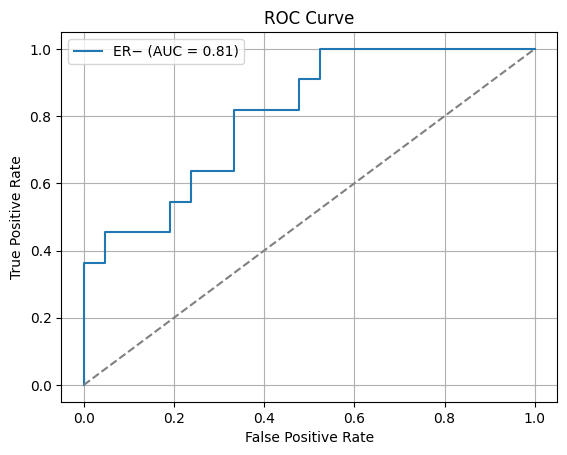

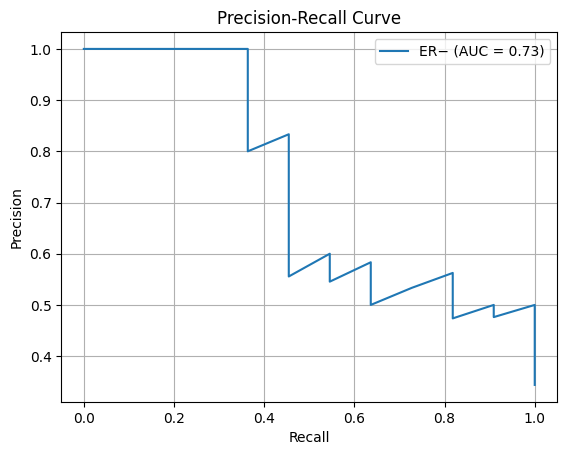

In [ ]:
def roc_pr_curves(results_dict, label_prefix):
    y_true = results_dict["y_true"]
    y_proba = results_dict["y_proba"]

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    return {
        "fpr": fpr, "tpr": tpr, "roc_auc": auc(fpr, tpr),
        "precision": precision, "recall": recall, "pr_auc": auc(recall, precision),
        "label": label_prefix
    }

roc_pr_er_neg = roc_pr_curves(results_er_negative_with_tune, "ER−")

#ROC Curve
plt.figure()
plt.plot(roc_pr_er_neg["fpr"], roc_pr_er_neg["tpr"], label=f"ER− (AUC = {roc_pr_er_neg['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

#P-R Curve
plt.figure()
plt.plot(roc_pr_er_neg["recall"], roc_pr_er_neg["precision"], label=f"ER− (AUC = {roc_pr_er_neg['pr_auc']:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
def probability_boxplots_ern(results_dict, title_suffix=""):

    y_true = results_dict["y_true"]
    y_proba = results_dict["y_proba"]

    boxplot_data = pd.DataFrame({
        'Response probability': y_proba,
        'Response': np.where(y_true == 1, 'Responder (pCR/RCB-0/I)', 'Non-Responder (RD/RCB-II/III)')
    })

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Response', y='Response probability',
                data=boxplot_data,
                palette={'Responder (pCR/RCB-0/I)': 'skyblue', 'Non-Responder (RD/RCB-II/III)': 'lightcoral'})
    plt.title(f'Response probability per {title_suffix} group')
    plt.xlabel('Response')
    plt.ylabel('Response probability')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

/tmp/ipython-input-19-2460795971.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response', y='Response probability',


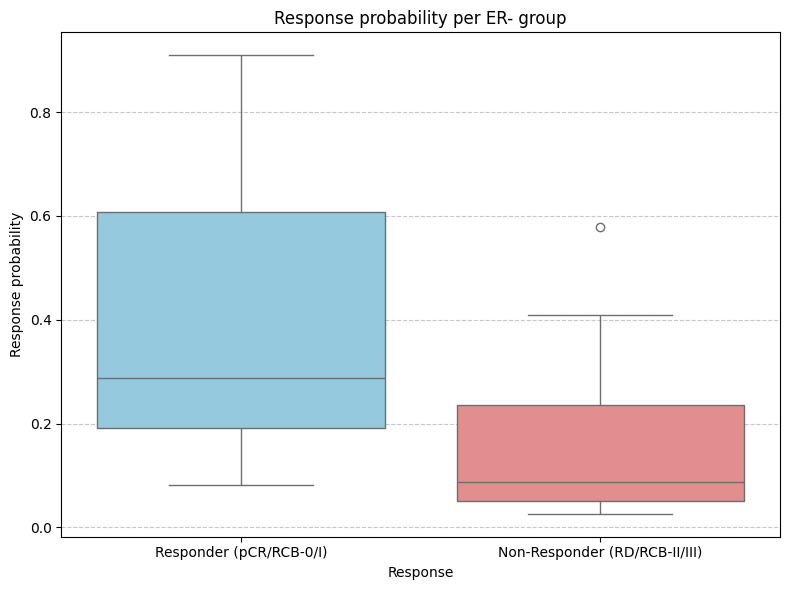

In [ ]:
probability_boxplots_ern(results_er_negative_with_tune, title_suffix="ER-")

In [ ]:
#Finding the treshild
y_true = results_er_negative_with_tune["y_true"]
y_proba = results_er_negative_with_tune["y_proba"]

precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

precision_trimmed = precision[:-1]
recall_trimmed = recall[:-1]

beta = 2
f2 = (1 + beta**2) * (precision_trimmed * recall_trimmed) / ((beta**2 * precision_trimmed + recall_trimmed) + 1e-10)

best_idx = np.argmax(f2)

#Metrisc
best_threshold = thresholds[best_idx]
best_recall = recall_trimmed[best_idx]
best_precision = precision_trimmed[best_idx]
best_f2 = f2[best_idx]

print(f"Best treshold for F2: {best_threshold:.3f}")
print(f"Recall: {best_recall:.3f}")
print(f"Precision: {best_precision:.3f}")
print(f"F2-score: {best_f2:.3f}")

Best treshold for F2: 0.081
Recall: 1.000
Precision: 0.500
F2-score: 0.833


ER+

In [15]:
def analyze_er_withgrid_1_for_erp(er_status_value, df_meta_final, df_expr_final,
                           top_n_genes=100, threshold=0.05, test_size=0.2, cv=5, use_tuning=False, verbose=True):

    #filtering data
    valid_labels = [ "RCB-0", "RCB-I", "RCB-0/I", "RCB-II", "RCB-III"]
    meta = df_meta_final[
        (df_meta_final["er_status_ihc"] == er_status_value) &
        (df_meta_final["pathologic_response_pcr_rd"].isin(valid_labels))
    ].copy()

    #0/1 label
    meta["pCR_label"] = meta["pathologic_response_pcr_rd"].isin([ "RCB-0", "RCB-I", "RCB-0/I"]).astype(int)

    if verbose:
        print(f"\n Analysis for ER{er_status_value}")
        print(f"Amount of probes: {meta.shape[0]}")
        print(f"(0=RD, 1=pCR):\n{meta['pCR_label'].value_counts()}\n")

    expr = df_expr_final[meta.index].T
    y = meta["pCR_label"]

    #Train and test data
    train_indices, test_indices = train_test_split(
        meta.index,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    X_train_full = expr.loc[train_indices]
    y_train_full = y.loc[train_indices]

    X_test = expr.loc[test_indices]
    y_test = y.loc[test_indices]

    if verbose:
        print(f"Train dataset:")
        print(y_train_full.value_counts())
        print(f"Test dataset:")
        print(y_test.value_counts())

    #Gene seleciton and training
    selector = SelectKBest(mutual_info_classif, k=top_n_genes)
    selector.fit(X_train_full, y_train_full)
    top_genes = X_train_full.columns[selector.get_support()]

    X_train = X_train_full[top_genes]
    X_test = X_test[top_genes]

    smote_sampler = SMOTE(random_state=42)

    if use_tuning:
        best_params = tune_xgboost_hyperparams_withtqdm(X_train, y_train_full, cv=cv, scoring='f2')
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42,
            **best_params
        )
    else:
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42
        )

    model_pipeline = Pipeline([
        ('sampler', smote_sampler),
        ('classifier', xgb_model)
    ])

    model_pipeline.fit(X_train, y_train_full)
    y_proba_test = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= threshold).astype(int)

    #Metrics
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    roc_auc = roc_auc_score(y_test, y_proba_test)
    acc = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    bal_acc = (sens + spec) / 2

    if verbose:
        grupa = "ER+" if er_status_value == "P" else "ER−"
        print(f"\nResults for (top {top_n_genes} genes) for {grupa}")
        print("Confusion matrix:")
        print(cm)
        print(f"AUC:                 {roc_auc:.2f}")
        print(f"Accuracy:            {acc:.2f}")
        print(f"Sensitivity (Recall):{sens:.2f}")
        print(f"Specificity:         {spec:.2f}")
        print(f"PPV (Precision):     {ppv:.2f}")
        print(f"NPV:                 {npv:.2f}")
        print(f"Balanced Accuracy:   {bal_acc:.2f}")

    return {
        "group": "ER+" if er_status_value == "P" else "ER−",
        "top_genes": top_genes,
        "AUC": roc_auc,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "Balanced_Accuracy": bal_acc,
        "y_true": y_test,
        "y_proba": y_proba_test,
        "y":y
    }

In [28]:
print("Analyzing ER+ group with tuning")
results_er_positive_with_tune = analyze_er_withgrid_1_for_erp(
    er_status_value="P",
    df_meta_final=df_meta_final,
    df_expr_final=df_expr_final,
    top_n_genes=100,
    threshold=0.14,
    test_size=0.2,
    use_tuning=True,
    cv=4,
    verbose=True
)


Analyzing ER+ group with tuning

 Analysis for ERP
Amount of probes: 79
(0=RD, 1=pCR):
pCR_label
0    61
1    18
Name: count, dtype: int64

Train dataset:
pCR_label
0    49
1    14
Name: count, dtype: int64
Test dataset:
pCR_label
0    12
1     4
Name: count, dtype: int64
Tuning (324 combinantions, cv=4)


Tuning (f2):   0%|          | 0/324 [00:00<?, ?it/s]


Best params:
colsample_bytree: 0.6
learning_rate: 0.05
max_depth: 3
min_child_weight: 1
n_estimators: 200
Best f2: 0.463

Results for (top 100 genes) for ER+
Confusion matrix:
[[7 5]
 [2 2]]
AUC:                 0.67
Accuracy:            0.56
Sensitivity (Recall):0.50
Specificity:         0.58
PPV (Precision):     0.29
NPV:                 0.78
Balanced Accuracy:   0.54


In [18]:
def analyze_er_withgrid_1_for_erp_wirh_RD(er_status_value, df_meta_final, df_expr_final,
                           top_n_genes=100, threshold=0.05, test_size=0.2, cv=5, use_tuning=False, verbose=True):

    #filtering data
    valid_labels = ["pCR", "RCB-0", "RCB-I", "RD", "RCB-0/I", "RCB-II", "RCB-III"]
    meta = df_meta_final[
        (df_meta_final["er_status_ihc"] == er_status_value) &
        (df_meta_final["pathologic_response_pcr_rd"].isin(valid_labels))
    ].copy()

    #0/1 label
    meta["pCR_label"] = meta["pathologic_response_pcr_rd"].isin(["pCR", "RCB-0", "RCB-I", "RCB-0/I"]).astype(int)

    if verbose:
        print(f"\n Analysis for ER{er_status_value}")
        print(f"Amount of probes: {meta.shape[0]}")
        print(f"(0=RD, 1=pCR):\n{meta['pCR_label'].value_counts()}\n")

    expr = df_expr_final[meta.index].T
    y = meta["pCR_label"]

    #Train and test data
    train_indices, test_indices = train_test_split(
        meta.index,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    X_train_full = expr.loc[train_indices]
    y_train_full = y.loc[train_indices]

    X_test = expr.loc[test_indices]
    y_test = y.loc[test_indices]

    if verbose:
        print(f"Train dataset:")
        print(y_train_full.value_counts())
        print(f"Test dataset:")
        print(y_test.value_counts())

    #Gene seleciton and training
    selector = SelectKBest(mutual_info_classif, k=top_n_genes)
    selector.fit(X_train_full, y_train_full)
    top_genes = X_train_full.columns[selector.get_support()]

    X_train = X_train_full[top_genes]
    X_test = X_test[top_genes]

    smote_sampler = SMOTE(random_state=42)

    if use_tuning:
        best_params = tune_xgboost_hyperparams_withtqdm(X_train, y_train_full, cv=cv, scoring='f2')
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42,
            **best_params
        )
    else:
        xgb_model = XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="logloss",
            random_state=42
        )

    model_pipeline = Pipeline([
        ('sampler', smote_sampler),
        ('classifier', xgb_model)
    ])

    model_pipeline.fit(X_train, y_train_full)
    y_proba_test = model_pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= threshold).astype(int)

    #Metrics
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    roc_auc = roc_auc_score(y_test, y_proba_test)
    acc = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    bal_acc = (sens + spec) / 2

    if verbose:
        grupa = "ER+" if er_status_value == "P" else "ER−"
        print(f"\nResults for (top {top_n_genes} genes) for {grupa}")
        print("Confusion matrix:")
        print(cm)
        print(f"AUC:                 {roc_auc:.2f}")
        print(f"Accuracy:            {acc:.2f}")
        print(f"Sensitivity (Recall):{sens:.2f}")
        print(f"Specificity:         {spec:.2f}")
        print(f"PPV (Precision):     {ppv:.2f}")
        print(f"NPV:                 {npv:.2f}")
        print(f"Balanced Accuracy:   {bal_acc:.2f}")

    return {
        "group": "ER+" if er_status_value == "P" else "ER−",
        "top_genes": top_genes,
        "AUC": roc_auc,
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "Balanced_Accuracy": bal_acc,
        "y_true": y_test,
        "y_proba": y_proba_test,
        "y":y
    }

In [29]:
print("Analyzing ER+ group with tuning and RD")
results_er_positive_with_tune_with_RD = analyze_er_withgrid_1_for_erp_wirh_RD(
    er_status_value="P",
    df_meta_final=df_meta_final,
    df_expr_final=df_expr_final,
    top_n_genes=100,
    threshold=0.14,
    test_size=0.2,
    use_tuning=True,
    cv=4,
    verbose=True
)

Analyzing ER+ group with tuning and RD

 Analysis for ERP
Amount of probes: 244
(0=RD, 1=pCR):
pCR_label
0    215
1     29
Name: count, dtype: int64

Train dataset:
pCR_label
0    172
1     23
Name: count, dtype: int64
Test dataset:
pCR_label
0    43
1     6
Name: count, dtype: int64
Tuning (324 combinantions, cv=4)


Tuning (f2):   0%|          | 0/324 [00:00<?, ?it/s]


Best params:
colsample_bytree: 0.8
learning_rate: 0.05
max_depth: 3
min_child_weight: 1
n_estimators: 200
Best f2: 0.600

Results for (top 100 genes) for ER+
Confusion matrix:
[[35  8]
 [ 5  1]]
AUC:                 0.53
Accuracy:            0.73
Sensitivity (Recall):0.17
Specificity:         0.81
PPV (Precision):     0.11
NPV:                 0.88
Balanced Accuracy:   0.49


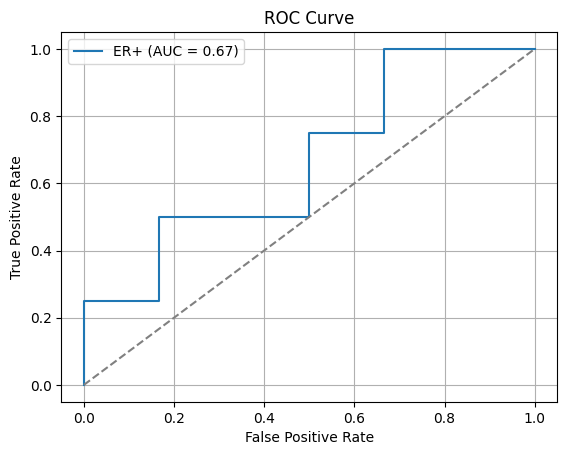

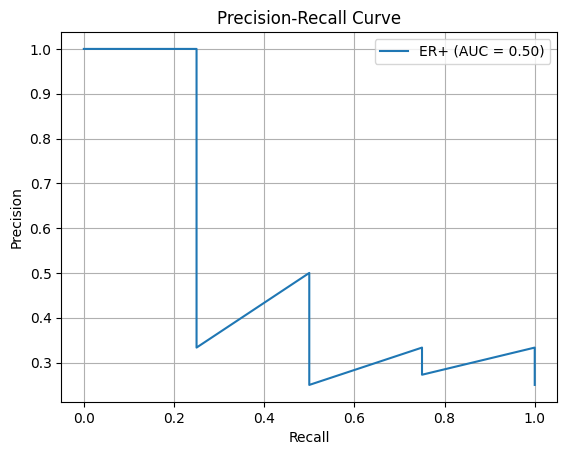

In [30]:
def roc_pr_curves(results_dict, label_prefix):
    y_true = results_dict["y_true"]
    y_proba = results_dict["y_proba"]

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    return {
        "fpr": fpr, "tpr": tpr, "roc_auc": auc(fpr, tpr),
        "precision": precision, "recall": recall, "pr_auc": auc(recall, precision),
        "label": label_prefix
    }

roc_pr_er_pos = roc_pr_curves(results_er_positive_with_tune, "ER+")

#ROC Curve
plt.figure()
plt.plot(roc_pr_er_pos["fpr"], roc_pr_er_pos["tpr"], label=f"ER+ (AUC = {roc_pr_er_pos['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

#P-R Curve
plt.figure()
plt.plot(roc_pr_er_pos["recall"], roc_pr_er_pos["precision"], label=f"ER+ (AUC = {roc_pr_er_pos['pr_auc']:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#Finding the treshild
y_true = results_er_positive_with_tune["y_true"]
y_proba = results_er_positive_with_tune["y_proba"]

precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

precision_trimmed = precision[:-1]
recall_trimmed = recall[:-1]

beta = 2
f2 = (1 + beta**2) * (precision_trimmed * recall_trimmed) / ((beta**2 * precision_trimmed + recall_trimmed) + 1e-10)

best_idx = np.argmax(f2)

#Metrisc
best_threshold = thresholds[best_idx]
best_recall = recall_trimmed[best_idx]
best_precision = precision_trimmed[best_idx]
best_f2 = f2[best_idx]

print(f"Best treshold for F2: {best_threshold:.3f}")
print(f"Recall: {best_recall:.3f}")
print(f"Precision: {best_precision:.3f}")
print(f"F2-score: {best_f2:.3f}")

Best treshold for F2: 0.031
Recall: 1.000
Precision: 0.333
F2-score: 0.714


In [23]:
def probability_boxplots_erp(results_dict, title_suffix=""):

    y_true = results_dict["y_true"]
    y_proba = results_dict["y_proba"]

    boxplot_data = pd.DataFrame({
        'Response probability': y_proba,
        'Response': np.where(y_true == 1, 'Responder (RCB-0/I)', 'Non-Responder (RCB-II/III)')
    })

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Response', y='Response probability',
                data=boxplot_data,
                palette={'Responder (RCB-0/I)': 'skyblue', 'Non-Responder (RCB-II/III)': 'lightcoral'})
    plt.title(f'Response probability per {title_suffix} group')
    plt.xlabel('Response')
    plt.ylabel('Response probability')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

/tmp/ipython-input-23-3286981609.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Response', y='Response probability',


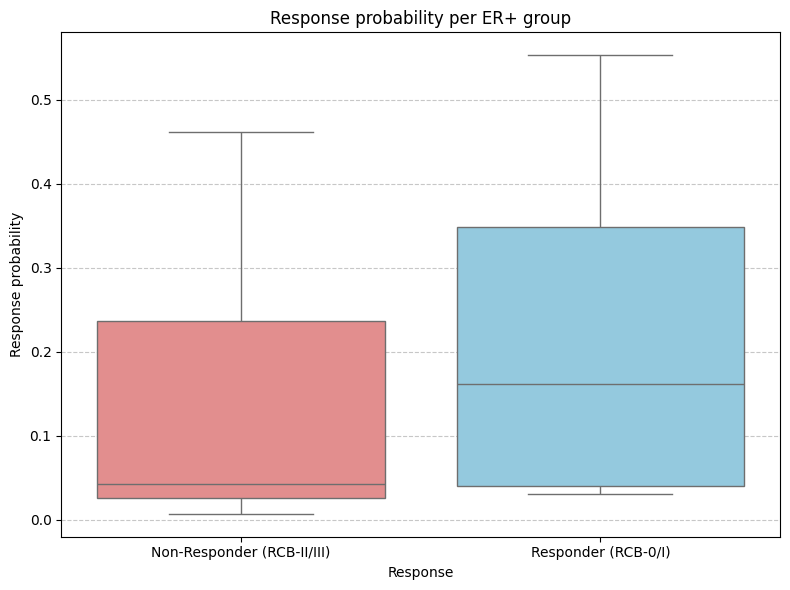

In [37]:
probability_boxplots_erp(results_er_positive_with_tune, title_suffix="ER+")

In [39]:
results_list = [results_er_negative_with_tune, results_er_positive_with_tune]

metrics_df = pd.DataFrame({
    r["group"]: {
        "AUC": r["AUC"],
        "Accuracy": r["Accuracy"],
        "Precision": r["PPV"],
        "Recall (Sensitivity)": r["Sensitivity"],
        "Specificity": r["Specificity"],
        "NPV": r["NPV"],
        "Balanced Accuracy": r["Balanced_Accuracy"]
    }
    for r in results_list
})

metrics_df

,ER−,ER+
AUC,0.805195,0.666667
Accuracy,0.656250,0.562500
Precision,0.500000,0.285714
Recall (Sensitivity),0.636364,0.500000
Specificity,0.666667,0.583333
NPV,0.777778,0.777778
Balanced Accuracy,0.651515,0.541667


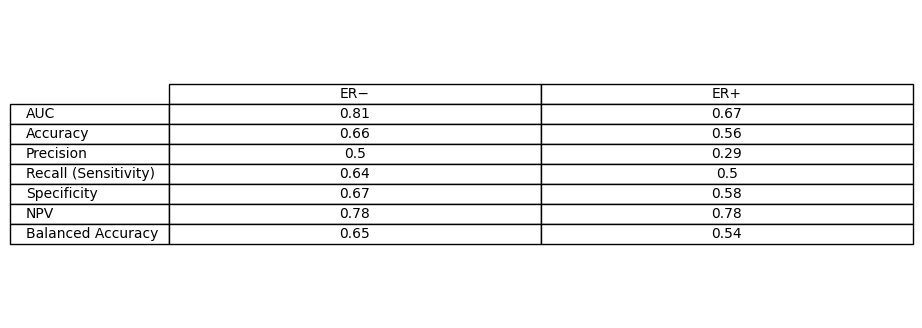

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')

table = ax.table(
    cellText=metrics_df.round(2).values,
    rowLabels=metrics_df.index,
    colLabels=metrics_df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.savefig("metrics_table_XGBOOST.png", bbox_inches='tight', dpi=300)

In [41]:
# Analyzing genes
genes_pos = set(results_er_positive_with_tune["top_genes"])
genes_neg = set(results_er_negative_with_tune["top_genes"])

common_genes = genes_pos & genes_neg
unique_pos = genes_pos - genes_neg
unique_neg = genes_neg - genes_pos

max_len = max(len(common_genes), len(unique_pos), len(unique_neg))

def pad_list(l, n):
    return list(l) + [None]*(n - len(l))

gene_df = pd.DataFrame({
    "Common": pad_list(common_genes, max_len),
    "Unique ER+": pad_list(unique_pos, max_len),
    "Unique ER−": pad_list(unique_neg, max_len)
})

gene_df.head(10)


,Common,Unique ER+,Unique ER−
0,None,31807_at,207226_at
1,None,211363_s_at,221122_at
2,None,210247_at,220377_at
3,None,202819_s_at,202439_s_at
4,None,203181_x_at,211131_s_at
5,None,214083_at,222225_at
6,None,211250_s_at,216875_x_at
7,None,218757_s_at,216892_at
8,None,207996_s_at,206818_s_at
9,None,208329_at,219442_at


In [42]:
probes = gene_df[gene_df['Common'].notna()]['Common'].tolist()


https://www.thermofisher.com/pl/en/home/life-science/microarray-analysis/microarray-data-analysis/genechip-array-annotation-files.html

In [43]:
annotation_file = pd.read_csv('/content/drive/MyDrive/modelowanie/projekt/HG-U133A.na36.annot.csv', sep=',', comment='#', dtype=str)
annotation_file.head()

,Probe Set ID,GeneChip Array,Species Scientific Name,Annotation Date,Sequence Type,Sequence Source,Transcript ID(Array Design),Target Description,Representative Public ID,Archival UniGene Cluster,...,Gene Ontology Cellular Component,Gene Ontology Molecular Function,Pathway,InterPro,Trans Membrane,QTL,Annotation Description,Annotation Transcript Cluster,Transcript Assignments,Annotation Notes
0,1007_s_at,Human Genome U133A Array,Homo sapiens,"Mar 30, 2016",Exemplar sequence,Affymetrix Proprietary Database,U48705mRNA,U48705 /FEATURE=mRNA /DEFINITION=HSU48705 Hum...,U48705,---,...,0005576 // extracellular region // inferred fr...,0000166 // nucleotide binding // inferred from...,---,IPR000421 // Coagulation factor 5/8 C-terminal...,---,---,This probe set was annotated using the Matchin...,"BC008716(16),BC013400(16),BC070070(16),ENST000...",BC008716 // Homo sapiens discoidin domain rece...,OTTHUMT00000257572 // vega // 8 // Cross Hyb M...
1,1053_at,Human Genome U133A Array,Homo sapiens,"Mar 30, 2016",Exemplar sequence,GenBank,M87338,M87338 /FEATURE= /DEFINITION=HUMA1SBU Human r...,M87338,---,...,0005634 // nucleus // inferred from electronic...,0000166 // nucleotide binding // inferred from...,DNA_replication_Reactome // GenMAPP,IPR000523 // Magnesium chelatase ChlI domain /...,---,---,This probe set was annotated using the Matchin...,"AB451243(9),BC002813(13),BT007058(9),ENST00000...",AB451243 // Homo sapiens RFC2 mRNA for replica...,OTTHUMT00000351337 // vega // 4 // Cross Hyb M...
2,117_at,Human Genome U133A Array,Homo sapiens,"Mar 30, 2016",Exemplar sequence,Affymetrix Proprietary Database,X51757cds,X51757 /FEATURE=cds /DEFINITION=HSP70B Human h...,X51757,---,...,0005737 // cytoplasm // inferred from direct a...,0000166 // nucleotide binding // inferred from...,---,IPR004753 // Cell shape determining protein Mr...,---,---,This probe set was annotated using the Matchin...,"AK295212(16),BC035665(16),ENST00000309758(16),...",AK295212 // Homo sapiens cDNA FLJ51847 complet...,NONHSAT007178 // noncode // 3 // Cross Hyb Mat...
3,121_at,Human Genome U133A Array,Homo sapiens,"Mar 30, 2016",Exemplar sequence,GenBank,X69699,X69699 /FEATURE= /DEFINITION=HSPAX8A H.sapiens...,X69699,---,...,0005634 // nucleus // inferred from direct ass...,0000978 // RNA polymerase II core promoter pro...,---,IPR001523 // Paired domain // 2.4E-71 /// IPR0...,---,---,This probe set was annotated using the Matchin...,"AK096795(14),BC001060(15),ENST00000263334(14),...","AK096795 // Homo sapiens cDNA FLJ39476 fis, cl...",GENSCAN00000020329 // ensembl // 1 // Cross Hy...
4,1255_g_at,Human Genome U133A Array,Homo sapiens,"Mar 30, 2016",Exemplar sequence,Affymetrix Proprietary Database,L36861expanded_cds,L36861 /FEATURE=expanded_cds /DEFINITION=HUMG...,L36861,---,...,0001750 // photoreceptor outer segment // infe...,0005509 // calcium ion binding // inferred fro...,---,IPR002048 // EF-hand domain // 1.0E-10 /// IPR...,---,---,This probe set was annotated using the Matchin...,"AK125780(16),BC031663(16),ENST00000053469(16),...","AK125780 // Homo sapiens cDNA FLJ43792 fis, cl...",---


In [44]:
gene_info = annotation_file[annotation_file['Probe Set ID'].isin(probes)]

print(gene_info[['Probe Set ID', 'Gene Symbol', 'Gene Title']])

Empty DataFrame
Columns: [Probe Set ID, Gene Symbol, Gene Title]
Index: []
